# Intro to Machine Learning 
## Group Assignment - Group 2
### 21 April 2023

In [6]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

from matplotlib.colors import ListedColormap
%matplotlib inline

import os
import glob
from pathlib import Path

In [9]:
home = str(Path.home())

print(os.getcwd())
old_dir = os.getcwd()
#os.chdir(os.path.join(os.path.curdir, 'Documents/GitHub/ML-Project'))


C:\Users\imeld\work\ML-Project


In [11]:
# constant value switches
MAKE_FILES=False
READ_FILES = True
FILE_MASK = "dublinbikes*.csv"

In [119]:
# read in all the dublinbikes csv file s (from dublinbikes/)
# and combine them into one dataframe
folder_path = 'dublinbikes/'
file_list = glob.glob(folder_path + FILE_MASK)

print(file_list)
full_data = pd.DataFrame(pd.read_csv(file_list[0]))

for i in range(1, len(file_list)):
    data = pd.read_csv(file_list[i])
    df = pd.DataFrame(data)
    full_data = pd.concat([full_data, df])
print(full_data.sample(3))


In [5]:
#backup the dataframe to disk
full_data.to_csv("data/full_data.csv", index= False)

In [ ]:
#find which stations weren't open the whole time
openStations = full_data['NAME'].value_counts()
#exclude stations which weren't open the long enough 
openStations = (openStations >=300000).rename_axis('NAME').reset_index(name='include')


In [ ]:
#openStations
full_data = pd.merge(full_data, openStations, how='left', on = 'NAME', \
              indicator=False)
m=full_data['include']
full_data = full_data[m]
full_data['NAME'].value_counts()

In [ ]:
# write out full data to csv file
if MAKE_FILES : full_data.to_csv("data/full_data.csv", index=False)
if READ_FILES : full_data = pd.read_csv("data/full_data.csv")

In [ ]:
# check stations remaining
print((full_data['NAME']).unique())

In [ ]:
full_data = full_data.sort_values(['NAME', 'TIME' ])
full_data.head()

In [ ]:
#cluster stations
data = full_data
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2020-04-01')]
data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)

#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data['DATETIME'].dt.round('H')

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "

data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(3)

In [ ]:
#group data into clusters
clustering_df = data[['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'DAY_TYPE', 'TIME_TYPE', 'OCCUPANCY_PCT','CLUSTER_GROUP']]
clustering_df = clustering_df.groupby(['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CLUSTER_GROUP'],as_index=False)['OCCUPANCY_PCT'].mean()
clustering_df  = clustering_df.set_index('STATION ID')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['NAME', 'STATION ID','LATITUDE', 'LONGITUDE'] , columns=['CLUSTER_GROUP'], values='OCCUPANCY_PCT')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('NAME')
clustering_df = clustering_df.dropna()

clustering_df.sample(3)

## K-means clustering analysis 

In [ ]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
#clustering algo
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
KM = KMeans(n_clusters=5) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations[locations['Cluster'] ==0].head(3)

In [ ]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(locations['LATITUDE'],locations['LONGITUDE'], locations['Cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map

Based on the map the location stations choosen were: 
- 'HANOVER QUAY' in Grand Canal Dock (blue) + FITZWILLIAM SQUARE EAST
- 'YORK STREET EAST' in south Dublin  (red) + 'NEW CENTRAL BANK'
- 'MATER HOSPITAL'- north side, hospital (green) (PARNELL SQUARE NORTH, Rotunda hospital)

In [ ]:
selected_stations = pd.DataFrame(
    {
        "NAME": ['HANOVER QUAY', 'FITZWILLIAM SQUARE EAST', 'YORK STREET EAST', 'NEW CENTRAL BANK', 
'MATER HOSPITAL', 'PARNELL SQUARE NORTH'],
        "cluster": [0, 0, 1, 1, 2, 2]
    }
)

In [ ]:
print(data[['NAME', 'cluster']].drop_duplicates())

In [ ]:
# get dataframe with only selected stations
data = pd.merge(full_data, selected_stations, how='left', on = 'NAME', \
              indicator=False)
data = data.dropna()
data['NAME'].unique()

In [ ]:
data.to_csv("data/station_data.csv", index=False)

In [ ]:
data = data.sort_values(['NAME', 'TIME' ])

In [ ]:
# map locations of bike stations
locations  = data[['LATITUDE', 'LONGITUDE', 'cluster']].drop_duplicates()
data.sample(50)
colordict = {0: 'blue', 1: 'red', 2: 'green'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.0)

for LATITUDE, LONGITUDE, cluster in zip(locations['LATITUDE'],locations['LONGITUDE'],locations['cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map
  

In [ ]:
#data = pd.read_csv("data/station_data.csv")
# sort data frame and calculate normalised usage
data = data.drop('include', axis = 1)
data  = data.sort_values(['NAME', 'TIME' ])
data['usage'] = abs(data['AVAILABLE BIKES'].diff())/data['BIKE STANDS']

In [ ]:
if MAKE_FILES : data.to_csv("data/station_data.csv", index=False)

In [ ]:
# check - there should be 1 na in usage
data.isna().sum()

In [ ]:
round(data.describe(), 3)

#%%
ct = pd.crosstab(index=data['NAME'], columns=data['cluster'])

print(ct)

In [ ]:
# create variables for visualisation and modelling
data.drop_duplicates(keep= 'first',inplace=True)

dates = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["TIME"]]
#get date and time columns
data['datetime'] = dates
data['time'] = data.datetime.dt.time
data['date'] = data.datetime.dt.date
data['date_for_merge'] = data.datetime.dt.round('d')

startDate = min(dates).date()

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['day_number'] = data.datetime.dt.dayofweek
data['day_type'] = np.where(data['day_number'] <= 4, 'Weekday', (np.where(data['day_number'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "

data["time_type"] = data.datetime.apply(bin_time)
data['hour'] = data.datetime.dt.hour
data['month'] = data.datetime.dt.month
data['week'] = data.datetime.dt.week
data['year'] = data.datetime.dt.year
data['dayIndex'] = [(d - startDate).days for d in data['date']]
data['yearWeek'] = data.year *100+data.week

In [ ]:
print(data.columns.values)
data.to_csv("data/station_data.csv", index=False)

array([datetime.date(2019, 12, 15), datetime.date(2019, 12, 16),
       datetime.date(2019, 12, 17), datetime.date(2019, 12, 22),
       datetime.date(2019, 12, 23), datetime.date(2019, 12, 24),
       datetime.date(2019, 12, 25), datetime.date(2019, 12, 30),
       datetime.date(2019, 12, 31), datetime.date(2020, 1, 1),
       datetime.date(2020, 1, 3), datetime.date(2020, 1, 4),
       datetime.date(2020, 1, 5), datetime.date(2020, 1, 6),
       datetime.date(2020, 1, 13), datetime.date(2020, 1, 14),
       datetime.date(2020, 1, 23), datetime.date(2020, 1, 24),
       datetime.date(2020, 1, 25), datetime.date(2020, 1, 27),
       datetime.date(2020, 1, 28), datetime.date(2020, 1, 29),
       datetime.date(2020, 1, 30), datetime.date(2020, 1, 31),
       datetime.date(2020, 2, 1)], dtype=object)

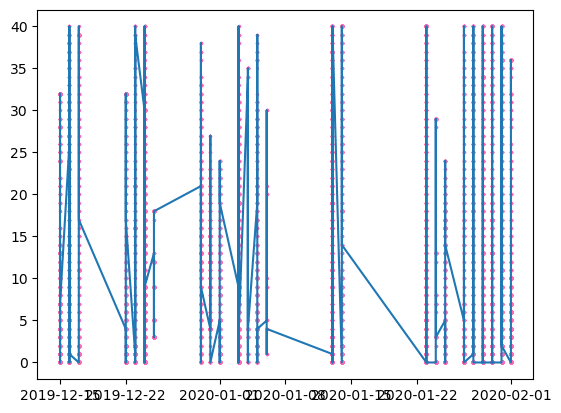

In [126]:
# check which days are missing in 2019/20
df = data.copy()
from datetime import date
range_start = date(2019, 12, 15)
range_end = date(2020, 2, 1)

m = (df.date >= range_start) & (df.date <= range_end)
df_short = df[m].sort_values(by='datetime')
plt.plot(df_short.date,df_short['AVAILABLE BIKES'])

#plt.scatter(df_short.date,df_short['AVAILABLE BIKES'], s=2, color='hotpink')
df_short.date.unique()


In [ ]:
#12: 18-21,  26-29
#01: 2, 7 - 12, 15-22, 26, 

## Q1 Effect of the Pandemic

In [13]:
data = pd.read_csv("data/station_data.csv")

In [ ]:
mask_cluster0 = data.cluster == 0  # Masking taken from tutorial 2 of ML 
mask_cluster1 = data.cluster == 1
mask_cluster2 = data.cluster == 2

cluster0 = data[mask_cluster0]
cluster1 = data[mask_cluster1]
cluster2 = data[mask_cluster2]

In [ ]:
cluster0.dropna(inplace=True)
cluster1.dropna(inplace=True)
cluster2.dropna(inplace=True)

### Creating data frames or each station

"HANOVER QUAY"

"FITZWILLIAM SQUARE EAST"

"MATER HOSPITAL"

"NEW CENTRAL BANK"

"PARNELL SQUARE NORTH" 

"YORK STREET EAST"

In [ ]:
mask_hanover = data.NAME == "HANOVER QUAY"
mask_fitzwilliam = data.NAME == "FITZWILLIAM SQUARE EAST"
mask_mater = data.NAME == "MATER HOSPITAL"

hanover_data = data[mask_hanover]
fitzwilliam_data = data[mask_fitzwilliam]
mater_data = data[mask_mater]

In [ ]:
hanover_data['usage'] = hanover_data['AVAILABLE BIKES'].diff()
print(hanover_data)
print(hanover_data["usage"].isnull().sum())

In [ ]:
fitzwilliam_data['usage'] = fitzwilliam_data['AVAILABLE BIKES'].diff()
print(fitzwilliam_data)
print(fitzwilliam_data["usage"].isnull().sum())

In [ ]:
mater_data["usage"] = mater_data["AVAILABLE BIKES"].diff()
print(mater_data)
mater_data["usage"].isnull().sum()

In [ ]:
hanover_data = hanover_data.dropna()
fitzwilliam_data = fitzwilliam_data.dropna()
mater_data = mater_data.dropna()

### Yearly bike usage

In [ ]:
def total_year_bike_usage(yyyy, dataset):
    
     '''
    For example
    
    2021, hanover_data
    '''
    
    year_data = dataset[dataset.year == yyyy]
    usage = year_data["usage"]
    return(sum(abs(usage)))
total_year_bike_usage(2021, hanover_data)

## Monthly bike usage

In [ ]:
def total_monthly_bike_usage(yyyy, m, dataset):
     '''
    For example
    
    2018, 12, hanover_data
    '''
    
    year_data = dataset[dataset.year == yyyy]
    month_data = year_data[year_data.month == m]

    month_usage = month_data["usage"]
    return(sum(abs(month_usage)))

print(total_monthly_bike_usage(2018, 12, hanover_data))
print(total_monthly_bike_usage(2019, 3, hanover_data))

### Weekly bike usage

In [ ]:
def total_weekly_bike_usage(yyyy, w, dataset):
    
     '''
    For example
    
    2019, 27, hanover_data
    '''
    
    year_data = dataset[dataset.year == yyyy]
    week_data = year_data[year_data.week == w]

    week_usage = week_data["usage"]
    return(sum(abs(week_usage)))

total_weekly_bike_usage(2019, 27, hanover_data)

In [ ]:
#Day index bike usage
def total_dayindex_bike_usage(di, dataset):
    di_data = dataset[dataset.dayIndex == di]
    
    di_usage = di_data["usage"]
    print(sum(abs(di_usage)))
    
print(total_dayindex_bike_usage(700, hanover_data))

# date
def date_bike_usage(yyyymmdd, dataset):    
    '''
    For example
    
    "2021-01-04", hanover_data
    '''
    
    dates = pd.to_datetime(dataset.TIME, format = "%Y-%m-%d %H:%M:%S")
    date_vector = pd.DatetimeIndex(dates.dt.date)
    day_index = date_vector == yyyymmdd
    
    day_of_interest = dates[day_index]
    usage = dataset[day_index]["usage"]
    print(sum(abs(usage))) 
    
date_bike_usage("2021-01-04", hanover_data)
date_bike_usage("2021-07-04", hanover_data)

# hourly
def hourly_bike_usage(yyyymmdd, hour, dataset):
    '''
    For example
    
    "2021-01-04", hanover_data
    '''
    date_data = dataset[dataset.year == yyyy]
    week_data = year_data[year_data.week == w]

    week_usage = week_data["usage"]
    print(sum(abs(week_usage)))


### Yearly usage data frame

In [ ]:
years = [2018, 2019, 2020, 2021]


In [ ]:
print(cluster0.dayIndex.nunique())
print(cluster0["dayIndex"].unique())

cluster0_usage = []
for i in years:
    cluster0_usage.append(total_year_bike_usage(i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in years:
    cluster1_usage.append(total_year_bike_usage(i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in years:
    cluster2_usage.append(total_year_bike_usage(i, cluster2))
print(cluster2_usage)


yudf = {
    'Year': years,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
yudf = pd.DataFrame(yudf)
print(yudf)


In [ ]:
ax = plt.gca()

yudf.plot(x = "Year", y = "Cluster 0", label ="cluster 0", ax = ax)
yudf.plot(x = "Year", y = "Cluster 1", label ="cluster 1", ax = ax)
yudf.plot(x = "Year", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("Total Yearly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
yudf.plot()

### Monthly usage data frame

In [ ]:
months = range(1,13)

In [ ]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2019, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2019, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2019, i, cluster2))
print(cluster2_usage)


mudf_19 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_19 = pd.DataFrame(mudf_19)
print(mudf_19)

In [ ]:
ax = plt.gca()

mudf_19.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_19.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_19.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2019 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2018, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2018, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2018, i, cluster2))
print(cluster2_usage)


mudf_18 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_18 = pd.DataFrame(mudf_18)
print(mudf_18)

ax = plt.gca()

mudf_18.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_18.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_18.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2018 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2020, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2020, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2020, i, cluster2))
print(cluster2_usage)


mudf_20 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_20 = pd.DataFrame(mudf_20)
print(mudf_20)

ax = plt.gca()

mudf_20.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_20.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_20.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2020 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
cluster0_usage = []
for i in months:
    cluster0_usage.append(total_monthly_bike_usage(2021, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in months:
    cluster1_usage.append(total_monthly_bike_usage(2021, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in months:
    cluster2_usage.append(total_monthly_bike_usage(2021, i, cluster2))
print(cluster2_usage)


mudf_21 = {
    'Month': months,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
mudf_21 = pd.DataFrame(mudf_21)
print(mudf_20)

ax = plt.gca()

mudf_21.plot(x = "Month", y = "Cluster 0", label ="cluster 0", ax = ax)
mudf_21.plot(x = "Month", y = "Cluster 1", label ="cluster 1", ax = ax)
mudf_21.plot(x = "Month", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2021 Total Monthly Bike Usage by Cluster")
plt.legend()
plt.show()

### Weekly

In [ ]:
weeks = range(1,53)
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2018, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2018, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2018, i, cluster2))
print(cluster2_usage)


wudf_18 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_18 = pd.DataFrame(wudf_18)
print(wudf_18)

ax = plt.gca()

wudf_18.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_18.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_18.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2018 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2019, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2019, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2019, i, cluster2))
print(cluster2_usage)


wudf_19 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_19 = pd.DataFrame(wudf_19)
print(wudf_19)

ax = plt.gca()

wudf_19.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_19.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_19.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2019 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2021, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2021, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2021, i, cluster2))
print(cluster2_usage)


wudf_21 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_21 = pd.DataFrame(wudf_21)
print(wudf_21)

ax = plt.gca()

wudf_21.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_21.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_21.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2021 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

In [ ]:
cluster0_usage = []
for i in weeks:
    cluster0_usage.append(total_weekly_bike_usage(2020, i, cluster0))
print(cluster0_usage)

cluster1_usage = []
for i in weeks:
    cluster1_usage.append(total_weekly_bike_usage(2020, i, cluster1))
print(cluster1_usage)

cluster2_usage = []
for i in weeks:
    cluster2_usage.append(total_weekly_bike_usage(2020, i, cluster2))
print(cluster2_usage)


wudf_20 = {
    'Week': weeks,
    "Cluster 0":cluster0_usage,
    "Cluster 1":cluster1_usage,
    "Cluster 2":cluster2_usage
}
wudf_20 = pd.DataFrame(wudf_20)
print(wudf_20)

ax = plt.gca()

wudf_20.plot(x = "Week", y = "Cluster 0", label ="cluster 0", ax = ax)
wudf_20.plot(x = "Week", y = "Cluster 1", label ="cluster 1", ax = ax)
wudf_20.plot(x = "Week", y = "Cluster 2", label ="cluster 2", ax = ax)

plt.title("2020 Total Weekly Bike Usage by Cluster")
plt.legend()
plt.show()

## Q2 Modelling 2020

#### To estimate how the city-bike usage would have been without the pandemic (e.g., 2020)

In [ ]:
data = pd.read_csv("station_data.csv")
print(data.sample(3))


In [ ]:
# create test and training sets
test_data = data[data['year']>= 2020]
test_data.to_csv("data/test.csv", index=False)
print(pd.crosstab(index=test_data['NAME'], columns = data['cluster']))
del test_data

#training set
training_data = data[data['year'] < 2020]
#len(training_data)
training_data.to_csv("data/training.csv", index=False)#%%

ct= pd.crosstab([training_data['NAME'], training_data['BIKE STANDS'], training_data['STATION ID']],training_data['cluster'])
print(ct)

In [45]:
# get absolute value of diff in available bikes from t-1 to t & normalise
data['usage'] = abs(data['AVAILABLE BIKES'].diff())/data['BIKE STANDS']

In [46]:
data.to_csv("data/station_data.csv", index = False)

In [41]:
pd.crosstab(index=data['NAME'], columns = data['cluster'] )

cluster                     0.0     1.0     2.0
NAME                                           
FITZWILLIAM SQUARE EAST  340191       0       0
HANOVER QUAY             341793       0       0
MATER HOSPITAL                0       0  340854
NEW CENTRAL BANK              0  341270       0
PARNELL SQUARE NORTH          0       0  341593
YORK STREET EAST              0  341632       0

In [42]:
data.describe()

STATION ID   BIKE STANDS  AVAILABLE BIKES       cluster  \
count  2.047333e+06  2.047333e+06     2.047333e+06  2.047333e+06   
mean   6.381083e+01  3.532811e+01     1.144178e+01  1.000226e+00   
std    1.888625e+01  7.456008e+00     9.912913e+00  8.163598e-01   
min    3.000000e+01  2.000000e+01     0.000000e+00  0.000000e+00   
25%    5.200000e+01  3.200000e+01     3.000000e+00  0.000000e+00   
50%    6.600000e+01  4.000000e+01     9.000000e+00  1.000000e+00   
75%    7.800000e+01  4.000000e+01     1.700000e+01  2.000000e+00   
max    8.900000e+01  4.000000e+01     4.300000e+01  2.000000e+00   

              usage  OCCUPANCY_PCT          FULL         EMPTY    DAY_NUMBER  \
count  2.047332e+06   2.047333e+06  2.047333e+06  2.047333e+06  2.047333e+06   
mean   8.828392e-03   3.133428e-01  1.147908e-01  1.005015e-02  3.001226e+00   
std    2.443451e-02   2.596465e-01  3.187694e-01  9.974541e-02  2.000778e+00   
min    0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00   1.000000e-01  0.000000e+00  0.000000e+00  1.000000e+00   
50%    0.000000e+00   2.750000e-01  0.000000e+00  0.000000e+00  3.000000e+00   
75%    0.000000e+00   4.750000e-01  0.000000e+00  0.000000e+00  5.000000e+00   
max    1.000000e+00   1.075000e+00  1.000000e+00  1.000000e+00  6.000000e+00   

               HOUR         MONTH          YEAR    day_number          hour  \
count  2.047333e+06  2.047333e+06  2.047333e+06  2.047333e+06  2.047333e+06   
mean   1.146683e+01  6.995045e+00  2.019765e+03  3.001262e+00  1.148091e+01   
std    6.913744e+00  3.404744e+00  1.019833e+00  2.000790e+00  6.919339e+00   
min    0.000000e+00  1.000000e+00  2.018000e+03  0.000000e+00  0.000000e+00   
25%    5.000000e+00  4.000000e+00  2.019000e+03  1.000000e+00  5.000000e+00   
50%    1.100000e+01  7.000000e+00  2.020000e+03  3.000000e+00  1.100000e+01   
75%    1.700000e+01  1.000000e+01  2.021000e+03  5.000000e+00  1.700000e+01   
max    2.300000e+01  1.200000e+01  2.022000e+03  6.000000e+00  2.300000e+01   

              month          week          year      dayIndex  
count  2.047333e+06  2.047333e+06  2.047333e+06  2.047333e+06  
mean   6.995039e+00  2.870915e+01  2.019765e+03  6.290014e+02  
std    3.404752e+00  1.485883e+01  1.019838e+00  3.646495e+02  
min    1.000000e+00  1.000000e+00  2.018000e+03  0.000000e+00  
25%    4.000000e+00  1.600000e+01  2.019000e+03  2.980000e+02  
50%    7.000000e+00  3.100000e+01  2.020000e+03  6.470000e+02  
75%    1.000000e+01  4.100000e+01  2.021000e+03  9.450000e+02  
max    1.200000e+01  5.300000e+01  2.022000e+03  1.249000e+03

In [47]:
data.head()

STATION ID                 TIME LAST UPDATED                     NAME  \
0          89  2018-08-01 12:30:02     12:19:52  FITZWILLIAM SQUARE EAST   
1          89  2018-08-01 12:35:02     12:31:35  FITZWILLIAM SQUARE EAST   
2          89  2018-08-01 12:40:02     12:34:03  FITZWILLIAM SQUARE EAST   
3          89  2018-08-01 12:45:02     12:34:03  FITZWILLIAM SQUARE EAST   
4          89  2018-08-01 12:50:02     12:45:54  FITZWILLIAM SQUARE EAST   

   BIKE STANDS  AVAILABLE BIKES STATUS  cluster  usage             DATETIME  \
0           40               37   Open      0.0    NaN  2018-08-01 12:19:52   
1           40               36   Open      0.0  0.025  2018-08-01 12:31:35   
2           40               37   Open      0.0  0.025  2018-08-01 12:34:03   
3           40               37   Open      0.0  0.000  2018-08-01 12:34:03   
4           40               37   Open      0.0  0.000  2018-08-01 12:45:54   

   ...      time        date  day_number  day_type  time_type  hour month  \
0  ...  12:30:02  2018-08-01           2   Weekday  11AM-3PM     12     8   
1  ...  12:35:02  2018-08-01           2   Weekday  11AM-3PM     12     8   
2  ...  12:40:02  2018-08-01           2   Weekday  11AM-3PM     12     8   
3  ...  12:45:02  2018-08-01           2   Weekday  11AM-3PM     12     8   
4  ...  12:50:02  2018-08-01           2   Weekday  11AM-3PM     12     8   

  week  year  dayIndex  
0   31  2018         0  
1   31  2018         0  
2   31  2018         0  
3   31  2018         0  
4   31  2018         0  

[5 rows x 32 columns]

In [44]:
ct1 = pd.crosstab(index = data['STATION ID'], columns = data['NAME'])
ct1

NAME        FITZWILLIAM SQUARE EAST  HANOVER QUAY  MATER HOSPITAL  \
STATION ID                                                          
30                                0             0               0   
52                                0             0               0   
66                                0             0               0   
68                                0        341793               0   
78                                0             0          340854   
89                           340191             0               0   

NAME        NEW CENTRAL BANK  PARNELL SQUARE NORTH  YORK STREET EAST  
STATION ID                                                            
30                         0                341593                 0  
52                         0                     0            341632  
66                    341270                     0                 0  
68                         0                     0                 0  
78                         0                     0                 0  
89                         0                     0                 0

Based on the clustering the location stations choosen were: 
- 'HANOVER QUAY' in Grand Canal Dock (blue) + FITZWILLIAM SQUARE EAST
- 'YORK STREET EAST' in south Dublin  (red) + 'NEW CENTRAL BANK'
- 'MATER HOSPITAL'- north side, hospital (green) (rotunda parnell st north)

In [17]:
def mapLocations(data) :
    locations  = data[['LATITUDE', 'LONGITUDE', 'cluster']].drop_duplicates()
    #data.sample(50)
    colordict = {0: 'blue', 1: 'red', 2: 'green'}
    dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.0)

    for LATITUDE, LONGITUDE, cluster in zip(locations['LATITUDE'],locations['LONGITUDE'],locations['cluster']):
        folium.CircleMarker(
            [LATITUDE, LONGITUDE],
            color = 'b',
            radius = 8,
            fill_color=colordict[cluster],
            fill=True,
            fill_opacity=0.9
            ).add_to(dublin_map)
    dublin_map   

### expl vars

In [18]:
data.sample(5)

STATION ID                 TIME LAST UPDATED  \
1913454          52  2020-09-15 23:30:02     23:26:33   
237592           89  2020-12-28 20:25:02     20:17:33   
943634           78  2021-03-25 05:55:02     05:44:57   
1758021          52  2019-01-31 01:30:01     01:23:19   
357926           68  2018-10-02 09:10:02     09:02:58   

                            NAME  BIKE STANDS  AVAILABLE BIKES STATUS  \
1913454         YORK STREET EAST           32                0   Open   
237592   FITZWILLIAM SQUARE EAST           40               24   Open   
943634            MATER HOSPITAL           40               14   Open   
1758021         YORK STREET EAST           32                1   Open   
357926              HANOVER QUAY           40               33   Open   

         include  cluster  usage  ...       date_for_merge OCCUPANCY_PCT FULL  \
1913454     True      1.0    0.0  ...  2020-09-15 23:00:00       0.00000    1   
237592      True      0.0    0.0  ...  2020-12-28 20:00:00       0.60000    0   
943634      True      2.0    0.0  ...  2021-03-25 06:00:00       0.35000    0   
1758021     True      1.0    0.0  ...  2019-01-31 01:00:00       0.03125    0   
357926      True      0.0    0.0  ...  2018-10-02 09:00:00       0.82500    0   

         EMPTY  DAY_NUMBER  DAY_TYPE   TIME_TYPE HOUR MONTH  YEAR  
1913454      0           1   Weekday  Overnight    23     9  2020  
237592       0           0   Weekday   8PM-11PM    20    12  2020  
943634       0           3   Weekday  Overnight     5     3  2021  
1758021      0           3   Weekday  Overnight     1     1  2019  
357926       0           1   Weekday   6AM-10AM     9    10  2018  

[5 rows x 22 columns]

In [106]:
#cluster stations
#data = data[data['STATUS'] == 'Open']

#?
#remove rows where no update actually occurs
#data = data.drop(['LAST UPDATED'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)

dates = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["TIME"]]
#get date and time columns
data['datetime'] = dates
data['time'] = data.datetime.dt.time
#data['time'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['date'] = data.datetime.dt.date
#data['date'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data.datetime.dt.round('d')


startDate = min(dates).date()
#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['day_number'] = data.datetime.dt.dayofweek
data['day_type'] = np.where(data['day_number'] <= 4, 'Weekday', (np.where(data['day_number'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "

data["time_type"] = data.datetime.apply(bin_time)
data['hour'] = data.datetime.dt.hour
data['month'] = data.datetime.dt.month
data['week'] = data.datetime.dt.week
data['year'] = data.datetime.dt.year
data['dayIndex'] = [(d - startDate).days for d in data['date']]
data['yearWeek'] = data.year *100+data.week


data.sample(5)

STATION ID                 TIME LAST UPDATED  \
1862375          52  2020-03-22 16:00:02     15:52:18   
309562           89  2021-09-11 07:55:02     07:52:30   
1237561          66  2020-10-09 07:10:03     07:05:51   
1922854          52  2020-10-18 12:15:02     12:12:52   
524354           68  2020-06-25 17:45:02     17:43:52   

                            NAME  BIKE STANDS  AVAILABLE BIKES STATUS  \
1862375         YORK STREET EAST           32               10   Open   
309562   FITZWILLIAM SQUARE EAST           40               16   Open   
1237561         NEW CENTRAL BANK           40               16   Open   
1922854         YORK STREET EAST           32               25   Open   
524354              HANOVER QUAY           40               19   Open   

         cluster  usage             DATETIME  ...      time        date  \
1862375      1.0  0.000  2020-03-22 15:52:18  ...  16:00:02  2020-03-22   
309562       0.0  0.000  2021-09-11 07:52:30  ...  07:55:02  2021-09-11   
1237561      1.0  0.000  2020-10-09 07:05:51  ...  07:10:03  2020-10-09   
1922854      1.0  0.000  2020-10-18 12:12:52  ...  12:15:02  2020-10-18   
524354       0.0  0.025  2020-06-25 17:43:52  ...  17:45:02  2020-06-25   

         day_number  day_type  time_type  hour month week  year  dayIndex  
1862375           6    Sunday   4PM-7PM     16     3   12  2020       599  
309562            5  Saturday  6AM-10AM      7     9   36  2021      1137  
1237561           4   Weekday  6AM-10AM      7    10   41  2020       800  
1922854           6    Sunday  11AM-3PM     12    10   42  2020       809  
524354            3   Weekday   4PM-7PM     17     6   26  2020       694  

[5 rows x 32 columns]

In [23]:
data = data.drop(columns='include')

## Create Test and Training sets

In [49]:
test_data = data[data['YEAR']>= 2020]
test_data.to_csv("data/test.csv", index=False)
pd.crosstab(index=test_data['NAME'], columns = data['cluster'])
del test_data

In [50]:
#training set
training_data = data[data['YEAR'] < 2020]
#len(training_data)
training_data.to_csv("data/training.csv", index=False)

In [51]:
pd.crosstab(index=[training_data['NAME'],training_data['year']], columns = data['cluster'])


cluster                         0.0    1.0    2.0
NAME                    year                     
FITZWILLIAM SQUARE EAST 2018  43663      0      0
                        2019  95551      0      0
HANOVER QUAY            2018  43663      0      0
                        2019  95687      0      0
MATER HOSPITAL          2018      0      0  43663
                        2019      0      0  95718
NEW CENTRAL BANK        2018      0  43663      0
                        2019      0  95751      0
PARNELL SQUARE NORTH    2018      0      0  43663
                        2019      0      0  95537
YORK STREET EAST        2018      0  43663      0
                        2019      0  95593      0

In [28]:
#print(training_data.describe())
pd.crosstab(index=training_data['NAME'], columns=training_data['YEAR'])
pd.crosstab(index=training_data['NAME'], columns=[training_data['BIKE STANDS'],training_data['cluster']])
pd.crosstab([training_data['NAME'], training_data['BIKE STANDS'], training_data['STATION ID']],training_data['cluster'])

cluster                                            0.0     1.0     2.0
NAME                    BIKE STANDS STATION ID                        
FITZWILLIAM SQUARE EAST 40          89          139214       0       0
HANOVER QUAY            40          68          139350       0       0
MATER HOSPITAL          40          78               0       0  139381
NEW CENTRAL BANK        40          66               0  139414       0
PARNELL SQUARE NORTH    20          30               0       0  139200
YORK STREET EAST        32          52               0  139256       0

## model results


In [163]:
df = training_data.copy()

In [166]:
# Let's get the standard deviation reflecting the change of bike availability within each hour-block of data
data_byDay = df.groupby('cluster').resample('d', on= 'datetime').std()
#data_byDay = data_byDay.rename(columns={'AVAILABLE BIKES': 'BIKES AVAILABILITY CHANGE'})
# Reset index names
data_byDay = data_byDay.drop(columns ='cluster')
data_byDay = data_byDay.reset_index()
#Change the time to hours only to make it easier to read
data_byDay.datetime = data_byDay.datetime.dt.date

data_byDay


cluster    datetime  STATION ID  BIKE STANDS  AVAILABLE BIKES     usage  \
0         0.0  2018-08-01   10.519074     0.000000        14.296765  0.057777   
1         0.0  2018-08-02   10.509126     0.000000        14.223131  0.042156   
2         0.0  2018-08-03   10.509126     0.000000        12.770573  0.044016   
3         0.0  2018-08-04   10.509126     0.000000         5.990750  0.019047   
4         0.0  2018-08-05   10.509126     0.000000         4.721919  0.016213   
...       ...         ...         ...          ...              ...       ...   
1549      2.0  2019-12-27         NaN          NaN              NaN       NaN   
1550      2.0  2019-12-28         NaN          NaN              NaN       NaN   
1551      2.0  2019-12-29         NaN          NaN              NaN       NaN   
1552      2.0  2019-12-30   24.028487    10.011869         6.459180  0.016106   
1553      2.0  2019-12-31   24.047013    10.019589         5.457634  0.012520   

      OCCUPANCY_PCT      FULL     EMPTY  DAY_NUMBER      HOUR  MONTH  YEAR  \
0          0.357419  0.367274  0.060302    0.000000  3.322050    0.0   0.0   
1          0.355578  0.458047  0.000000    0.072043  6.920416    0.0   0.0   
2          0.319264  0.353246  0.000000    0.058874  6.922898    0.0   0.0   
3          0.149769  0.442967  0.000000    0.058874  6.922508    0.0   0.0   
4          0.118048  0.327024  0.000000    0.058874  6.916224    0.0   0.0   
...             ...       ...       ...         ...       ...    ...   ...   
1549            NaN       NaN       NaN         NaN       NaN    NaN   NaN   
1550            NaN       NaN       NaN         NaN       NaN    NaN   NaN   
1551            NaN       NaN       NaN         NaN       NaN    NaN   NaN   
1552       0.150114  0.349649  0.000000    0.000000  5.086060    0.0   0.0   
1553       0.116183  0.269378  0.000000    0.124503  3.760603    0.0   0.0   

      day_number      hour  month  week  year  dayIndex  
0            0.0  3.320012    0.0   0.0   0.0       0.0  
1            0.0  6.928203    0.0   0.0   0.0       0.0  
2            0.0  6.928203    0.0   0.0   0.0       0.0  
3            0.0  6.928203    0.0   0.0   0.0       0.0  
4            0.0  6.928203    0.0   0.0   0.0       0.0  
...          ...       ...    ...   ...   ...       ...  
1549         NaN       NaN    NaN   NaN   NaN       NaN  
1550         NaN       NaN    NaN   NaN   NaN       NaN  
1551         NaN       NaN    NaN   NaN   NaN       NaN  
1552         0.0  5.085581    0.0   0.0   0.0       0.0  
1553         0.0  3.078410    0.0   0.0   0.0       0.0  

[1554 rows x 19 columns]

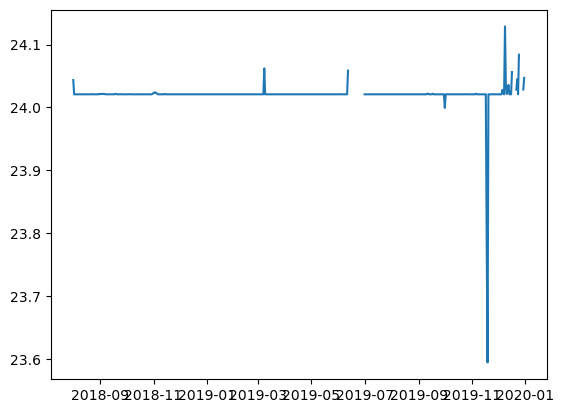

In [167]:
maskSpecificStation = data_byDay['cluster'] == 2
data2plot = data_byDay[maskSpecificStation] # columns: 0:STATION ID, 1:idx, 2:change

#Plot
plt.plot(np.array(data2plot)[:,1],np.array(data2plot)[:,2])
plt.show()

In [168]:
data_byDay.head(2)
data_byDay = data_byDay[['cluster', 'usage', 'dayIndex', 'month']]
data_byDay.head(2)


cluster     usage  dayIndex  month
0      0.0  0.057777       0.0    0.0
1      0.0  0.042156       0.0    0.0

### Sources used for coding:
1. https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot


2. https://www.statology.org/pandas-dropna-specific-column/


3. https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/


4. https://www.geeksforgeeks.org/matplotlib-pyplot-title-in-python/


5. https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns/


6. https://stackoverflow.com/questions/18265935/how-do-i-create-a-list-with-numbers-between-two-values

7. https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/

8. https://realpython.com/read-write-files-python/#text-file-types